# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy
import csv
import sklearn
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
PATH_TO_DATA = "data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict(zip(self.word2vec.keys(), range(nmax)))
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(list(self.word2vec.values()))
        self.words = np.array(list(self.word2id.keys())).reshape(-1,1)

    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words
        # We exclude the first word because it's the words itself
        if w in self.word2id:
            K_ids =  np.apply_along_axis(arr=self.words, 
                                         func1d=lambda x: -self.score(x[0], w),
                                          axis=1).argsort()[1:K+1]

            return [self.id2word[word] for word in K_ids]
        else:
            return None

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        # when error (key error etc) return None
        try:
            w1_id = self.word2id[w1]
            w2_id = self.word2id[w2]
            return self.embeddings[w1_id].dot(self.embeddings[w2_id])/(np.linalg.norm(self.embeddings[w2_id])*np.linalg.norm(self.embeddings[w1_id]))
        except:
            return None
        


In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'dic/crawl-300d-200k.vec'), nmax=200000)


Loaded 200000 pretrained word vectors


In [5]:
# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))


cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052403
paris france 0.7775108541288561
germany berlin 0.7420295235998392


In [6]:
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w1, w2v.most_similar(w1))

cat ['cats', 'kitty', 'kitten', 'feline', 'kitties']
dog ['dogs', 'puppy', 'Dog', 'doggie', 'canine']
dogs ['dog', 'pooches', 'Dogs', 'doggies', 'canines']
paris ['france', 'Paris', 'parisian', 'london', 'berlin']
germany ['austria', 'europe', 'german', 'berlin', 'poland']


In [10]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def load_sentences(self, filepath):
        sentences = []
        with open(filepath, 'r') as f:
            lines = f.read().splitlines()
            for line in lines:
                sentences.append(line.split(' '))
        print('Loaded %s sentences' % (len(sentences)))
        return sentences
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        for indice, sent in enumerate(sentences):
            emb = []
            weights = []
            if idf is False:
                for w in sent:
                    #checking if word is in dic
                    if self.w2v.word2id.get(w, -1) == -1:
                        continue
                    else:
                        emb.append(self.w2v.embeddings[self.w2v.word2id[w]])
                # mean of word vectors
                if emb:
                    sentemb.append(np.array(emb).mean(axis=0))
                else:
                    non_encoded_indices.append(indice)
                    
            else:
                 for w in sent:
                    #checking if word is in dic
                    if self.w2v.word2id.get(w, -1) == -1:
                        continue
                    else:
                        weights.append(idf[w])
                        emb.append(self.w2v.embeddings[self.w2v.word2id[w]])
                 # weighted average of word vectors
                 sentemb.append(np.average(np.array(emb), weights=weights , axis=0))
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        print('Query sentence: ', ' '.join(s))
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        K_ids = np.apply_along_axis(arr=keys, 
                                     func1d=lambda x: -self.score(x, query.reshape(-1)),
                                      axis=1).argsort()[1:K+1]
        for i in K_ids:
            print('Best matches: {}'.format(' '.join(sentences[i])))
        return [sentences[i] for i in K_ids]

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        return s1.dot(s2)/(np.linalg.norm(s1)*np.linalg.norm(s2))
    
    def score_sentences(self, s1, s2, idf=False):
        # cosine similarity.
        # Encoding sentences
        s1 = self.encode([s1], idf).reshape(-1)
        s2 = self.encode([s2], idf).reshape(-1)
        #  returning score
        return s1.dot(s2)/(np.linalg.norm(s1)*np.linalg.norm(s2))
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1
        
        for word in idf.keys():
            idf[word] = max(1, np.log10(len(sentences) / (idf[word])))
        return idf


In [11]:
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = s2v.load_sentences(os.path.join(PATH_TO_DATA, 'sentences.txt'))

# Build idf scores for each word
idf = s2v.build_idf(sentences)

Loaded 150736 sentences


In [12]:
# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
print(s2v.score_sentences('' if not sentences else sentences[7], '' if not sentences else sentences[13]))

s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
print(s2v.score_sentences('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Query sentence:  1 smiling african american boy . 
Best matches: an african american man smiling . 
Best matches: a little african american boy and girl looking up . 
Best matches: an afican american woman standing behind two small african american children . 
Best matches: an african american man is sitting . 
Best matches: a girl in black hat holding an african american baby . 
0.5726258859719607
Query sentence:  1 smiling african american boy . 
Best matches: an african american man smiling . 
Best matches: an african american man is sitting . 
Best matches: a little african american boy and girl looking up . 
Best matches: an afican american woman standing behind two small african american children . 
Best matches: a girl in black hat holding an african american baby . 
0.4751450875368781


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [13]:
class MWE():
    def __init__(self, nmax=50000):
        self.nmax = nmax
        
    def load_embeddings(self):
        self.english_w2v = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=self.nmax)
        self.french_w2v =  Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=self.nmax)
        
    def intersect(self):
        intersect, comm1, comm2  = np.intersect1d(self.english_w2v.words,
                                                  self.french_w2v.words,
                                                  return_indices=True)
        self.Y  = self.english_w2v.embeddings[comm1]
        self.X  = self.french_w2v.embeddings[comm2]
    
    def compute_alignment(self):
        u, s, vh = np.linalg.svd(self.Y.T.dot(self.X), full_matrices=True)
        self.W = u.dot(vh)
        
    def align(self, language, word, verbose):
        if language == 'French':
            if verbose:
                print('French word: {}'.format(word))
            word_id = self.french_w2v.word2id[word]
            return self.W.dot(self.french_w2v.embeddings[word_id])
        elif language == 'English':
            if verbose:
                print('English word: {}'.format(word))
            word_id = self.english_w2v.word2id[word]
            return self.W.T.dot(self.english_w2v.embeddings[word_id])
    
    def score(self, s1, s2):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        return s1.dot(s2)/(np.linalg.norm(s1)*np.linalg.norm(s2))
    
    def most_similar(self, language, word, K=5 , verbose=True):
        """
        Returns the most similar words after alignment.
        """
        if language == 'French':
            # aligning word
            aligned = self.align(language, word, verbose=True).reshape(-1)
            # K most similar words
            K_ids =  np.apply_along_axis(arr=self.english_w2v.embeddings, 
                                         func1d=lambda x: -self.score(x, aligned),
                                          axis=1).argsort()[:K]
            res = [self.english_w2v.id2word[word] for word in K_ids]
            if verbose:
                for word in res:
                    print('Best english words matches: {}'.format(word))
                print('---------')
            return res
        
        elif language == 'English':
            # aligning word
            aligned = self.align(language, word, verbose=True).reshape(-1)
             # K most similar words: self.score  -  np.argsort 
            K_ids =  np.apply_along_axis(arr=self.french_w2v.embeddings, 
                                         func1d=lambda x: -self.score(x, aligned),
                                          axis=1).argsort()[:K]
            res = [self.french_w2v.id2word[word] for word in K_ids]
            if verbose:
                for word in res:
                    print('Best french words matches: {}'.format(word))
                print('---------')
            return res
        

In [14]:
# 1 - Download and load 50k first vectors of
# https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#  https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

mwe = MWE(50000)
mwe.load_embeddings()

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [15]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)
mwe.intersect()

In [16]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector
mwe.compute_alignment()

In [17]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above
for i in range(5):
    word = mwe.french_w2v.words[np.random.randint(mwe.nmax)][0]
    mwe.most_similar(language='French', word=word)

French word: lude
Best english words matches: mayenne
Best english words matches: château
Best english words matches: allier
Best english words matches: blois
Best english words matches: châteaux
---------
French word: us
Best english words matches: us
Best english words matches: u
Best english words matches: isner
Best english words matches: navratilova
Best english words matches: mauresmo
---------
French word: package
Best english words matches: package
Best english words matches: packages
Best english words matches: functionality
Best english words matches: executable
Best english words matches: configurable
---------
French word: formalités
Best english words matches: procedures
Best english words matches: confidentiality
Best english words matches: reimbursement
Best english words matches: exemptions
Best english words matches: obligations
---------
French word: jarkko
Best english words matches: nieminen
Best english words matches: youzhny
Best english words matches: björkman
Be

In [18]:
for i in range(5):
    word = mwe.english_w2v.words[np.random.randint(mwe.nmax)][0]
    mwe.most_similar(language='English', word=word)

English word: drab
Best french words matches: terne
Best french words matches: bleuté
Best french words matches: beige
Best french words matches: pâle
Best french words matches: grisâtre
---------
English word: etiology
Best french words matches: pathologies
Best french words matches: pathologie
Best french words matches: pathologiques
Best french words matches: neurologiques
Best french words matches: pathologique
---------
English word: popular
Best french words matches: populaire
Best french words matches: populaires
Best french words matches: popular
Best french words matches: prisée
Best french words matches: popularité
---------
English word: deliver
Best french words matches: supply
Best french words matches: envoyant
Best french words matches: response
Best french words matches: transporte
Best french words matches: envoi
---------
English word: inexplicable
Best french words matches: étrange
Best french words matches: incohérence
Best french words matches: inquiétante
Best fre

If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [21]:
class SentenceClassification():
    def __init__(self, bov):
        self.s2v = bov
        self.filepaths = {'train': os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'),
                          'dev': os.path.join(PATH_TO_DATA,'SST/stsa.fine.dev'),
                          'test': os.path.join(PATH_TO_DATA,'SST/stsa.fine.test.X'),
                         }
        self.idf = False
        
    def load_data(self):
        self.X_train, self.Y_train = self.load_sentences('train')
        self.X_test, self.Y_test = self.load_sentences('test')
        self.X_dev, self.Y_dev = self.load_sentences('dev')

    def load_data_keras(self):
        self.X_train, self.Y_train = self.load_sentences_keras('train')
        self.X_test, self.Y_test = self.load_sentences_keras('test')
        self.X_dev, self.Y_dev = self.load_sentences_keras('dev')
    
    def build_idf(self):
        SETS = ['train', 'dev', 'test']
        X_non_encoded = []
        for set in SETS:
            with open(self.filepaths[set], 'r') as f:
                lines  = f.read().splitlines()
                for line in lines:
                    if set != 'test':
                        label = int(line[0])
                        sentence = line[2:]
                        X_non_encoded.append(sentence.split(' '))
                    else:
                        X_non_encoded.append(line.split(' '))

        self.idf = self.s2v.build_idf(X_non_encoded)

    def load_sentences(self, set):
        """
        Load sentences, given the set(train, test, dev) and encode the sentences
        """
        Y = []
        X_non_encoded = []
        with open(self.filepaths[set], 'r') as f:
            lines = f.read().splitlines()
            for line in lines:
                if set != 'test':
                    label = int(line[0])
                    sentence = line[2:]
                    X_non_encoded.append(sentence.split(' '))
                    Y.append(label)
                else:
                    X_non_encoded.append(line.split(' '))


                
        X = self.s2v.encode(X_non_encoded, idf=self.idf)
        Y = np.array(Y)        
        return X, Y
    
    def load_sentences_keras(self, set):
        """
        Load sentences, given the set(train, test, dev) without any procressing
        """
        Y = []
        X_non_encoded = []
        with open(self.filepaths[set], 'r') as f:
            lines = f.read().splitlines()
            for line in lines:
                if set != 'test':
                    label = int(line[0])
                    sentence = line[2:]
                    X_non_encoded.append(sentence)
                    Y.append(label)
                else:
                    X_non_encoded.append(line)
                
        Y = np.array(Y)        
        return X_non_encoded, Y

#### Mean encoding

In [22]:
# 2 - Encode sentences with the BoV model above
sc = SentenceClassification(s2v)
sc.load_data()

Logistic Regression on sentence embeddings

In [23]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=5,
                        solver='lbfgs',
                        multi_class='multinomial',
                        max_iter=1000)
lr.fit(sc.X_train, sc.Y_train)
print('Accuracy on train set:  {}'.format(lr.score(sc.X_train, sc.Y_train)))
print('Accuracy on dev set:  {}'.format(lr.score(sc.X_dev, sc.Y_dev)))


Accuracy on train set:  0.49929775280898875
Accuracy on dev set:  0.4396003633060854


L2 penalty tuning by cross validation

In [24]:
accuracies = []
l2_penalties = np.linspace(-2,1,20)
for l2 in l2_penalties:
    lr = LogisticRegression(random_state=5,
                            solver='lbfgs',
                            multi_class='multinomial',
                            max_iter=1000,
                            penalty='l2',
                            C=1/np.power(10,l2))
    lr.fit(sc.X_train, sc.Y_train)
    accuracies.append(lr.score(sc.X_dev, sc.Y_dev))

Text(0, 0.5, 'Accuracy on dev set')

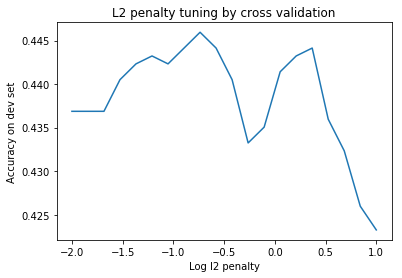

In [25]:
plt.plot(l2_penalties, accuracies)
plt.title('L2 penalty tuning by cross validation')
plt.xlabel('Log l2 penalty')
plt.ylabel('Accuracy on dev set')

In [26]:
best_penalty = l2_penalties[np.argsort(accuracies)[-1]]
print('Best L2 penalty is: {0:0.2f}'.format(np.power(10,best_penalty)))
best_penalty = 1/np.power(10,best_penalty)

Best L2 penalty is: 0.18


In [27]:
lr = LogisticRegression(random_state=5,
                        solver='lbfgs',
                        multi_class='multinomial',
                        max_iter=1000,
                        penalty='l2',
                        C=best_penalty)
lr.fit(sc.X_train, sc.Y_train)
print('Accuracy on train set:  {}'.format(lr.score(sc.X_train, sc.Y_train)))
print('Best accuracy on dev set:  {}'.format(lr.score(sc.X_dev, sc.Y_dev)))

Accuracy on train set:  0.5124063670411985
Best accuracy on dev set:  0.44595821980018163


In [28]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.
Y_pred_test = lr.predict(sc.X_test)
pd.DataFrame(Y_pred_test).to_csv('logreg_bov_y_test_sst.txt', index=False)

#### IDF encoding

In [29]:
sc = SentenceClassification(s2v)
sc.build_idf()
sc.load_data()

In [30]:
lr = LogisticRegression(random_state=5,
                        solver='lbfgs',
                        multi_class='multinomial',
                        max_iter=1000)
lr.fit(sc.X_train, sc.Y_train)
print('Accuracy on train set(IDF encoding):  {}'.format(lr.score(sc.X_train, sc.Y_train)))
print('Accuracy on dev set(IDF encoding):  {}'.format(lr.score(sc.X_dev, sc.Y_dev)))


Accuracy on train set(IDF encoding):  0.5003511235955056
Accuracy on dev set(IDF encoding):  0.4223433242506812


In [31]:
accuracies = []
l2_penalties = np.linspace(-2,2,20)
for l2 in l2_penalties:
    lr = LogisticRegression(random_state=5,
                            solver='lbfgs',
                            multi_class='multinomial',
                            max_iter=1000,
                            penalty='l2',
                            C=1/np.power(10,l2))
    lr.fit(sc.X_train, sc.Y_train)
    accuracies.append(lr.score(sc.X_dev, sc.Y_dev))

Text(0, 0.5, 'Accuracy on dev set')

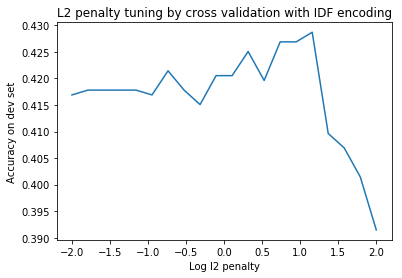

In [32]:
plt.plot(l2_penalties, accuracies)
plt.title('L2 penalty tuning by cross validation with IDF encoding')
plt.xlabel('Log l2 penalty')
plt.ylabel('Accuracy on dev set')

In [33]:
best_penalty = l2_penalties[np.argsort(accuracies)[-1]]
print('Best L2 penalty is: {0:0.2f}'.format(np.power(10,best_penalty)))
best_penalty = 1/np.power(10,best_penalty)

Best L2 penalty is: 14.38


In [34]:
lr = LogisticRegression(random_state=5,
                        solver='lbfgs',
                        multi_class='multinomial',
                        max_iter=1000,
                        penalty='l2',
                        C=best_penalty)
lr.fit(sc.X_train, sc.Y_train)
print('Accuracy on train set:  {}'.format(lr.score(sc.X_train, sc.Y_train)))
print('Best accuracy on dev set:  {}'.format(lr.score(sc.X_dev, sc.Y_dev)))

Accuracy on train set:  0.46289794007490637
Best accuracy on dev set:  0.4287011807447775


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [35]:
import keras

Using TensorFlow backend.


In [36]:
# 1 - Load train/dev/test sets of SST
sc = SentenceClassification(s2v)
sc.load_data_keras()

In [37]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/
sequences = []
sequences_val = []
sequences_test = []

# Computing vocabulary size in the train set. 
words = []
for sent in sc.X_train:
    words.extend(sent.split(' '))
nwords = len(set(words))


#maximum sentence length
max_len = 0

# preprocessing training data with one hot
for sent in sc.X_train:
    x = keras.preprocessing.text.one_hot(sent,
                                         n=nwords,
                                         lower=True,
                                         split=' ')
    if len(x)> max_len:
        max_len = len(x)
    sequences.append(x)

# preprocessing validation data with one hot
for sent in sc.X_dev:
    x = keras.preprocessing.text.one_hot(sent,
                                         n=nwords,
                                         lower=True,
                                         split=' ')
    sequences_val.append(x)    

# preprocessing validation data with one hot
for sent in sc.X_test:
    x = keras.preprocessing.text.one_hot(sent,
                                         n=nwords,
                                         lower=True,
                                         split=' ')
    sequences_test.append(x)   

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [38]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/


x_train = keras.preprocessing.sequence.pad_sequences(sequences,
                                           maxlen=20,
                                           dtype='int32',
                                           padding='pre',
                                           value=0.0)
x_val = keras.preprocessing.sequence.pad_sequences(sequences_val,
                                           maxlen=20,
                                           dtype='int32',
                                           padding='pre',
                                           value=0.0)
x_test = keras.preprocessing.sequence.pad_sequences(sequences_test,
                                           maxlen=max_len,
                                           dtype='int32',
                                           padding='pre',
                                           value=0.0)

In [39]:
#converting class labels to one hot vector

y_train = keras.utils.to_categorical(sc.Y_train, num_classes=5, dtype='float32')
y_val = keras.utils.to_categorical(sc.Y_dev, num_classes=5, dtype='float32')

## 4.2 - Design and train your model

In [40]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.



from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, Conv1D, Input, MaxPooling1D, Flatten, AveragePooling1D, Conv2D

embed_dim  = 10  # word embedding dimension
nhid       = 16  # number of hidden units in the LSTM
vocab_size = nwords  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='softmax'))


In [41]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          165810    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                1728      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
Total params: 167,623
Trainable params: 167,623
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

bs = 64
n_epochs = 5

history = model.fit(x_train,
                    y_train,
                    batch_size=bs,
                    epochs=n_epochs,
                    validation_data=(x_val, y_val))

Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 5s 590us/step - loss: 1.5797 - acc: 0.2733 - val_loss: 1.5688 - val_acc: 0.2534
Epoch 2/5
8544/8544 [==============================] - 3s 337us/step - loss: 1.5229 - acc: 0.3420 - val_loss: 1.4728 - val_acc: 0.3597
Epoch 3/5
8544/8544 [==============================] - 3s 337us/step - loss: 1.3645 - acc: 0.4224 - val_loss: 1.4267 - val_acc: 0.3624
Epoch 4/5
8544/8544 [==============================] - 3s 298us/step - loss: 1.2086 - acc: 0.4815 - val_loss: 1.4165 - val_acc: 0.3742
Epoch 5/5
8544/8544 [==============================] - 3s 310us/step - loss: 1.0864 - acc: 0.5492 - val_loss: 1.4432 - val_acc: 0.3760


In [43]:
def plot_training_error(history):
    plt.figure(figsize=(8,8))
    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label="training loss")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    plt.plot(history.history['val_loss'], label="validation loss")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    plt.legend()
    plt.subplot(2, 1, 2)

    plt.plot(history.history['acc'], label="training accuracy")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
   
    plt.plot(history.history['val_acc'], label="validation accuracy")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

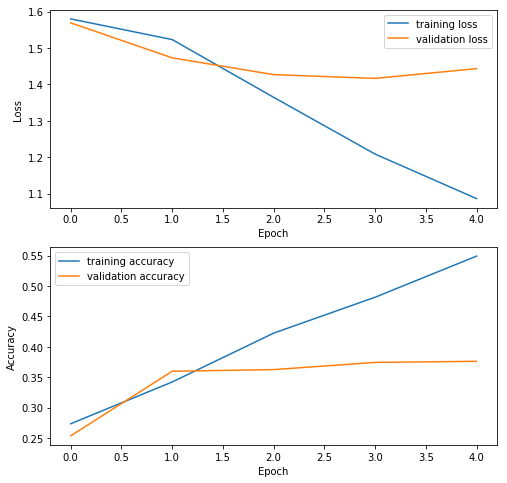

In [44]:
plot_training_error(history=history)

In [45]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

pd.DataFrame(model.predict_classes(x_test)).to_csv('logreg_lstm_y_test_sst.txt',
                                                   index=False)

## 4.3 -- innovate !

In [46]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.


To inovate we are going to build a model similar to the previous question but we are going to use a pretrained embedding based on the W2V used in the first question

#### Loading W2V

In [47]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'dic/crawl-300d-200k.vec'), nmax=200000)
s2v = BoV(w2v)
sc = SentenceClassification(s2v)
sc.load_data_keras()

Loaded 200000 pretrained word vectors


In [48]:
def custom_tokenize(sentences, w2v):
    """
    Custom tokenize function.
    Return the list of indices in w2v for each sentence in the dataset.
    """
    tokens = []
    #iterate over sentences
    for s in sentences:
        indices = []
        for w in s.split(' '):
            if w in w2v.word2id:
                indices.append(w2v.word2id[w])
        tokens.append(indices)
    return tokens

#### Processing sentences and labels

In [49]:
MAX_LEN = 30
NUM_CLASSES = 5

In [50]:
sequences_train = custom_tokenize(sc.X_train, w2v)
x_train = keras.preprocessing.sequence.pad_sequences(sequences_train,
                                           maxlen=MAX_LEN,
                                           dtype='int32',
                                           padding='post',
                                           value=0.0)

In [51]:
sequences_val = custom_tokenize(sc.X_dev, w2v)
x_val = keras.preprocessing.sequence.pad_sequences(sequences_val,
                                           maxlen=MAX_LEN,
                                           dtype='int32',
                                           padding='post',
                                           value=0.0)

In [52]:
sequences_test = custom_tokenize(sc.X_test, w2v)
x_test = keras.preprocessing.sequence.pad_sequences(sequences_test,
                                           maxlen=MAX_LEN,
                                           dtype='int32',
                                           padding='post',
                                           value=0.0)

In [53]:
y_train = keras.utils.to_categorical(sc.Y_train, num_classes=NUM_CLASSES, dtype='float32')
y_val = keras.utils.to_categorical(sc.Y_dev, num_classes=NUM_CLASSES, dtype='float32')

#### Defining the embedding layer with the w2v matrix

In [54]:
embedding_layer = Embedding(input_dim=w2v.embeddings.shape[0],
                            output_dim=w2v.embeddings.shape[1], 
                            input_length=MAX_LEN,
                            weights=[w2v.embeddings], 
                            trainable=False, 
                            name='embedding_layer')

#### Defining model

In [55]:
NHID = 32
DROPOUT = 0.2

In [56]:
sequence_input = keras.Input(shape=(MAX_LEN,),
                             dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
output_lstm = LSTM(NHID,
                   dropout=DROPOUT,
                   recurrent_dropout=DROPOUT)(embedded_sequences)
predictions = Dense(n_classes,
                    activation='softmax')(output_lstm)
model = keras.Model(sequence_input,
                    predictions)

In [57]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
embedding_layer (Embedding)  (None, 30, 300)           60000000  
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 60,042,789
Trainable params: 42,789
Non-trainable params: 60,000,000
_________________________________________________________________
None


In [58]:

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        = 'adam'

metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)


In [59]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

bs = 32
n_epochs = 10
history = model.fit(x_train,
                    y_train,
                    batch_size=bs,
                    epochs=n_epochs,
                    validation_data=(x_val, y_val))

Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 10s 1ms/step - loss: 1.5743 - acc: 0.2625 - val_loss: 1.5700 - val_acc: 0.2752
Epoch 2/10
8544/8544 [==============================] - 7s 870us/step - loss: 1.5140 - acc: 0.3182 - val_loss: 1.4110 - val_acc: 0.3678
Epoch 3/10
8544/8544 [==============================] - 7s 864us/step - loss: 1.3815 - acc: 0.3835 - val_loss: 1.3367 - val_acc: 0.3787
Epoch 4/10
8544/8544 [==============================] - 7s 867us/step - loss: 1.3215 - acc: 0.4036 - val_loss: 1.3073 - val_acc: 0.4187
Epoch 5/10
8544/8544 [==============================] - 7s 859us/step - loss: 1.2826 - acc: 0.4258 - val_loss: 1.2784 - val_acc: 0.4360
Epoch 6/10
8544/8544 [==============================] - 7s 858us/step - loss: 1.2480 - acc: 0.4458 - val_loss: 1.2680 - val_acc: 0.4387
Epoch 7/10
8544/8544 [==============================] - 7s 850us/step - loss: 1.2214 - acc: 0.4638 - val_loss: 1.2596 - val_acc: 0.4614
E

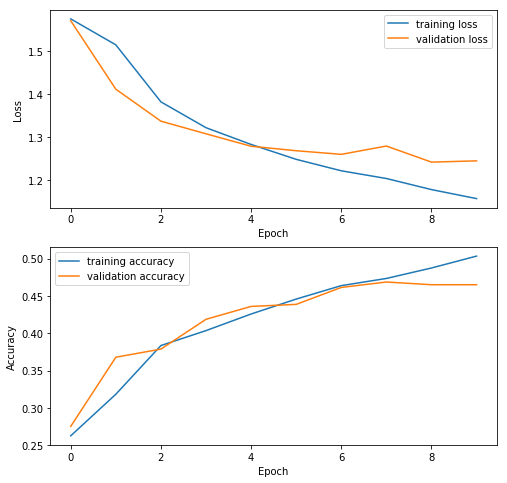

In [60]:
plot_training_error(history=history)

In [61]:
pd.DataFrame(np.argmax(model.predict(x_test), axis=1)).to_csv('pretrained_embedding_lstm_y_test_sst.txt',
                                                   index=False)